# Import & Clean Sensor Data

### Dataset Features:  
<strong>Instances:</strong>  53,752 (5 second interval)  

<strong>Attributes:</strong>  10

### Table of Contents<a name='table of contents'></a>
1. [Data Ingestion](#data ingestion)
2. [Data Wrangling](#data wrangling)  
    a. [Temperature Data](#temperature)  
    b. [Humidity Data](#humidity)  
    c. [CO&#8322; Data](#co2)  
    d. [Light Data](#light)  
    e. [Light Status](#light status)  
    f. [Noise Data](#noise)  
    g. [Bluetooth Devices Data](#bluetooth devices)  
    h. [Images](#images)  
    i. [Door Status](#door status)  
    j. [Occupancy Count](#occupancy count)  
3. [Concatenate Data](#concatenate data)  
4. [Dummy Variables](#dummy variables)  
5. [Resample Data](#resample data) 
6. [Category Variable](#occupancy level) 
7. [Save Data](#save data) 

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
sns.set_palette('RdBu', 10)


## Data Ingestion<a name='data ingestion'></a>

In [2]:
URL = 'https://raw.githubusercontent.com/georgetown-analytics/classroom-occupancy/master/dataset_builder/dataset-5sec.csv'

def fetch_data(fname='dataset-5sec.csv'):
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Defining fetching data from the URL
DATA = fetch_data()

In [3]:
# Read csv file in as a pandas dataframe with a DateTimeIndex: df
df = pd.read_csv('dataset-5sec.csv', index_col='datetime', parse_dates=True)

In [4]:
# Delete temperature_f and occupancy_category columns
df.drop(['temperature_f', 'occupancy_category'], axis=1, inplace=True)

In [5]:
# Slice data from Nick's office
df_nick = df.drop(df.loc['2017-03-25':'2017-05-16'].index)
df_nick = df_nick.drop(df_nick.loc['2017-06-03':'2017-06-10'].index)

# Slice Georgetown data
df.drop(df.loc['2017-05-17':'2017-05-24'].index, inplace=True)

In [6]:
# View updated list of days captured in the data: updated_byday
updated_byday = df.groupby(df.index.strftime('%D')).count()
print(updated_byday)

          temperature  humidity   co2  light  light_status  noise  \
03/25/17         5430      5430  5430   5430          5430   5430   
04/01/17         5730      5730  5730   5730          5730   5730   
04/08/17         5393      5393  5393   5393          5393   5393   
04/22/17         5606      5606  5606   5606          5606   5606   
04/29/17         5268      5268  5268   5268          5268   5268   
05/05/17         2389      2389  2389   2389          2389   2389   
05/06/17         5374      5374  5374   5374          5374   5374   
05/12/17         2233      2233  2233   2233          2233   2233   
05/13/17         5234      5234  5234   5234          5234   5234   
06/03/17         5528      5528  5528   5528          5528   5528   
06/10/17         5567      5567  5567   5567          5567   5567   

          bluetooth_devices  image_hist_change  door_status  occupancy_count  
03/25/17               5430               5430         5430             5430  
04/01/17     

In [7]:
# Export data from Nick's officeto a csv file: df_nick.csv
df_nick.to_csv('nick_updated.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53752 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 10 columns):
temperature          53752 non-null float64
humidity             53752 non-null float64
co2                  53752 non-null float64
light                53752 non-null float64
light_status         53752 non-null object
noise                53752 non-null float64
bluetooth_devices    53752 non-null float64
image_hist_change    53752 non-null float64
door_status          53752 non-null object
occupancy_count      53752 non-null float64
dtypes: float64(8), object(2)
memory usage: 4.5+ MB


## Data Wrangling<a name='data wrangling'></a>

### Temperature Data <a name='temperature'></a>
For Reference: The temperature sensor has a range of -40 to 125°C. OSHA recommends temperature control in the range of 20-24.4°C (68-76°F). 

In [9]:
# Create temperature dataframe with DateTimeIndex
temperature_data = df[['temperature']].copy()

In [10]:
# Summary statistics of temperature data
temperature_data.info()
temperature_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53752 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 1 columns):
temperature    53752 non-null float64
dtypes: float64(1)
memory usage: 839.9 KB


,temperature
count,53752.000000
mean,23.131898
std,1.401216
min,21.000000
25%,22.400000
50%,22.900000
75%,23.200000
max,29.400000


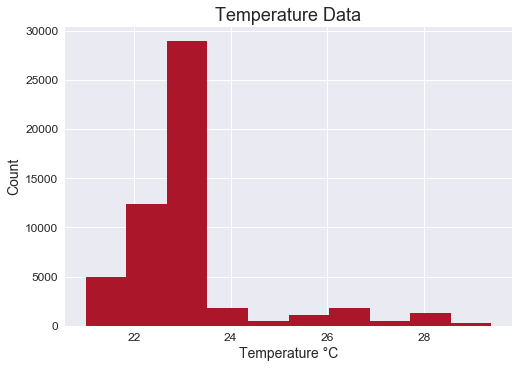

In [11]:
# Histogram of temperature data
plt.hist(temperature_data['temperature'])

plt.title('Temperature Data', size=18)
plt.xlabel('Temperature °C', size=14)
plt.ylabel('Count', size=14)
plt.tick_params(labelsize=12)

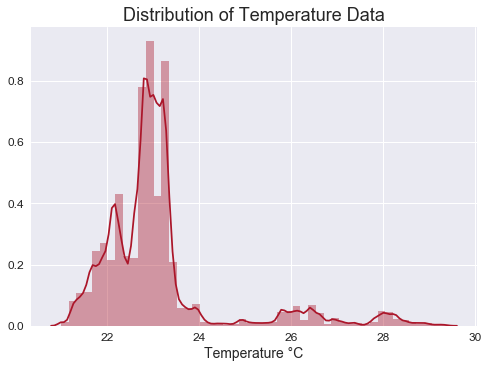

In [12]:
# Distribution of temperature data
sns.distplot(temperature_data['temperature'])

plt.title('Distribution of Temperature Data', size=18)
plt.xlabel('Temperature °C', size=14)
plt.tick_params(labelsize=12)

In [13]:
# Create temperature dataframe with a daily PeriodIndex: temp_period
temp_period = temperature_data.to_period(freq='D')

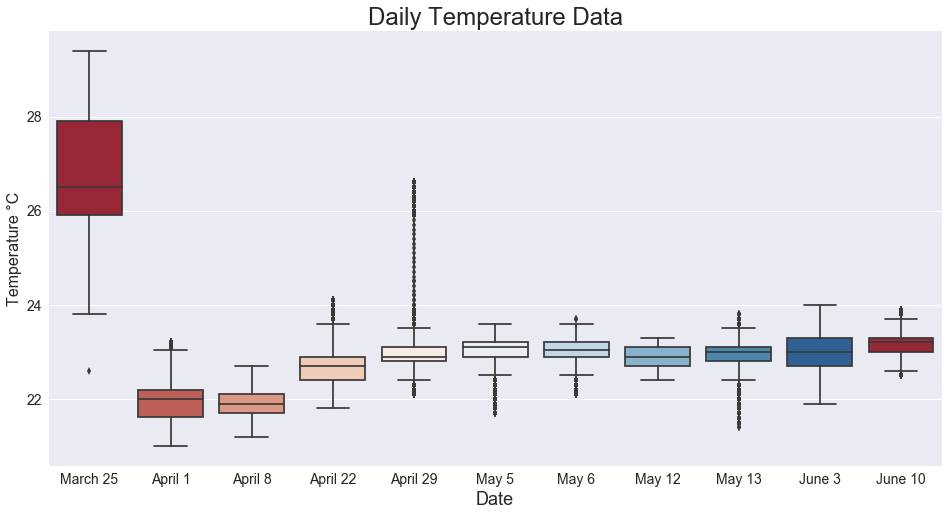

In [14]:
# Box-and-whisker plots for daily temperature data
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x=temp_period.index, y='temperature', data=temp_period,
            ax=ax, palette=sns.color_palette('RdBu', 10))

labels = (['March 25', 'April 1', 'April 8', 'April 22', 'April 29',
           'May 5', 'May 6', 'May 12', 'May 13', 'June 3', 'June 10'])
ax.set_title('Daily Temperature Data', fontsize= 24) 
ax.set_xlabel('Date', fontsize=18)
ax.set_xticklabels(labels)
ax.set_ylabel('Temperature °C', fontsize=16)
plt.tick_params(labelsize=14)
#plt.savefig('exploratory_data_analysis/daily_temperature_boxplots.png')

### Humidity <a name='humidity'></a>

For Reference: The sensor has a range of 0-100% relative humidity (RH). OSHA recommends humidity control in the range of 20%-60%.

In [15]:
# Create humidity dataframe with DateTimeIndex: humidity_data
humidity_data = df[['humidity']].copy()

In [16]:
humidity_data.info()
humidity_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53752 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 1 columns):
humidity    53752 non-null float64
dtypes: float64(1)
memory usage: 839.9 KB


,humidity
count,53752.000000
mean,39.475574
std,6.486531
min,20.800000
25%,37.700000
50%,39.800000
75%,44.600000
max,51.200000


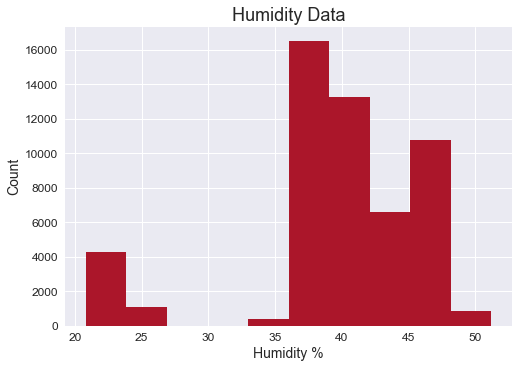

In [17]:
# Histogram of humidity data
plt.hist(humidity_data['humidity'])

plt.title('Humidity Data', size=18)
plt.xlabel('Humidity %', size=14)
plt.ylabel('Count', size=14)
plt.tick_params(labelsize=12)

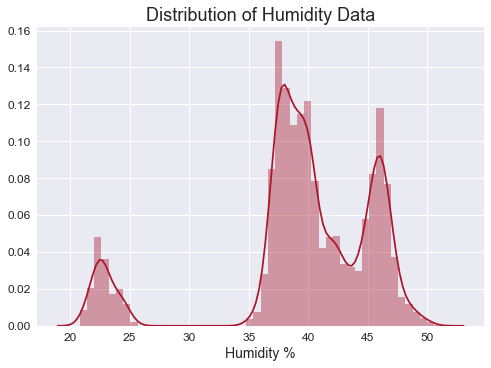

In [18]:
# Distribution of humidity data
sns.distplot(humidity_data['humidity'])

plt.title('Distribution of Humidity Data', size=18)
plt.xlabel('Humidity %', size=14)
plt.tick_params(labelsize=12)

In [19]:
# Create humidity dataframe with a daily PeriodIndex: humidity_period
humidity_period = humidity_data.to_period(freq='D')

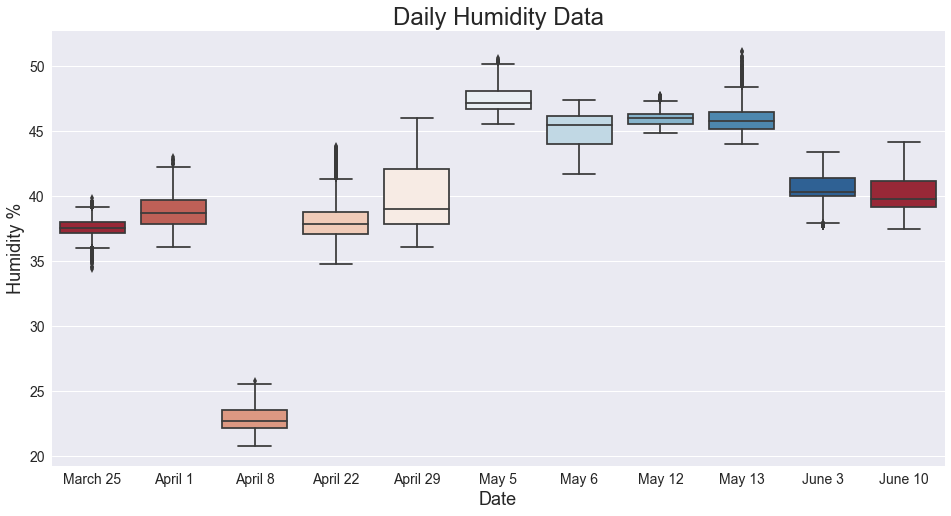

In [20]:
# Box-and-whisker plots for daily humidity data
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(x=humidity_period.index, y='humidity', data=humidity_period,
            ax=ax, palette=sns.color_palette('RdBu', 10))

labels = (['March 25', 'April 1', 'April 8', 'April 22', 'April 29', 'May 5',
           'May 6', 'May 12', 'May 13', 'June 3', 'June 10'])
ax.set_title('Daily Humidity Data',fontsize=24) 
ax.set_xlabel('Date', fontsize=18)
ax.set_xticklabels(labels)
ax.set_ylabel('Humidity %', fontsize=18)
plt.tick_params(labelsize=14)
#plt.savefig('exploratory_data_analysis/daily_humidity_boxplots.png')

### CO&#8322; Data <a name='co2'></a>
For Reference: The CO&#8322; sensor has a range of 0-2000 parts per million (ppm). OSHA recommends keeping indoor CO&#8322; levels below 1000 ppm.  
* 250-350 ppm: background (normal) outdoor air level  
* 350-1000 ppm: typical level found in occupied spaces with good air exchange  
* 1000-2000 ppm: level associated with complaints of drowsiness and poor air  

In [21]:
# Create CO2 dataframe with DateTimeIndex: co2_data
co2_data = df[['co2']].copy()

In [22]:
co2_data.info()
co2_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53752 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 1 columns):
co2    53752 non-null float64
dtypes: float64(1)
memory usage: 839.9 KB


,co2
count,53752.000000
mean,1236.181215
std,183.192328
min,629.000000
25%,1103.226117
50%,1262.000000
75%,1367.831402
max,2001.000000


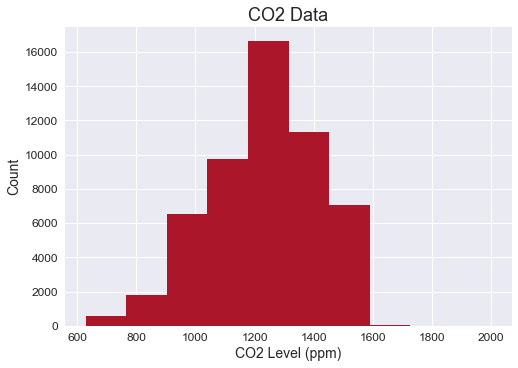

In [23]:
# Histogram of CO2 data
plt.hist(co2_data['co2'])

plt.title('CO2 Data', size=18)
plt.xlabel('CO2 Level (ppm)', size=14)
plt.ylabel('Count', size=14)
plt.tick_params(labelsize=12)

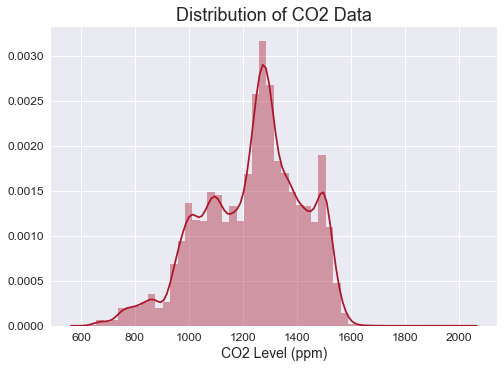

In [24]:
# Distribution of CO2 data
sns.distplot(co2_data['co2'])

plt.title('Distribution of CO2 Data', size=18)
plt.xlabel('CO2 Level (ppm)', size=14)
plt.tick_params(labelsize=12)

In [25]:
# Create CO2 dataframe with a daily PeriodIndex: co2_period
co2_period = co2_data.to_period(freq='D')

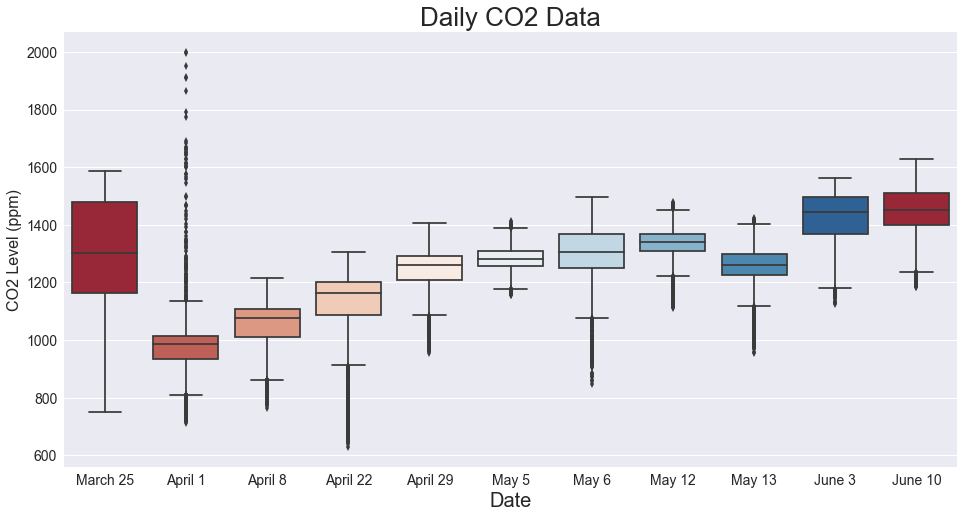

In [26]:
# Box-and-whisker plots of daily CO2 data
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x=co2_period.index, y='co2', data=co2_period,
            ax=ax, palette=sns.color_palette('RdBu', 10))

labels = (['March 25', 'April 1', 'April 8', 'April 22', 'April 29', 'May 5',
           'May 6', 'May 12', 'May 13', 'June 3', 'June 10'])

ax.set_title('Daily CO2 Data', fontsize=26) 
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('CO2 Level (ppm)', fontsize=16)
ax.set_xticklabels(labels)
plt.tick_params(labelsize=14)
#plt.savefig('exploratory_data_analysis/daily_co2.png')

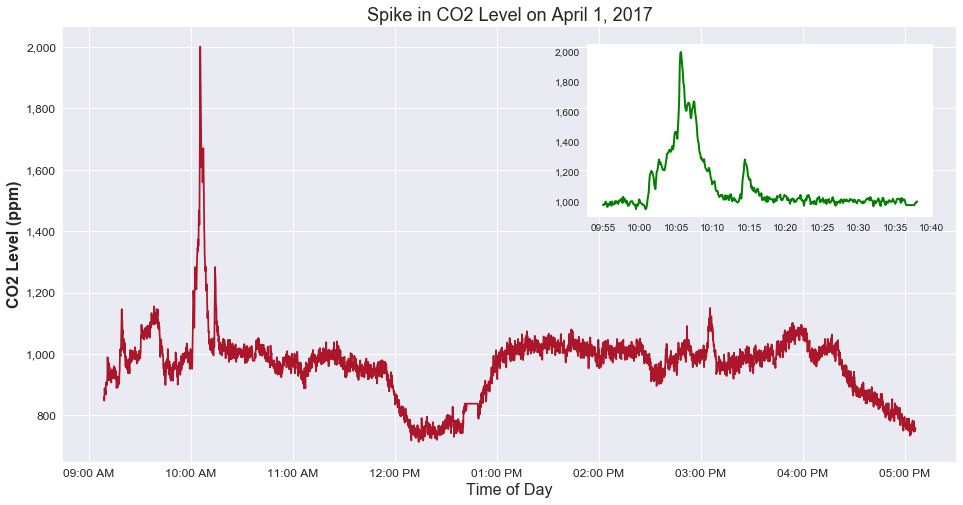

In [27]:
# Plot spike in CO2 level on April 1, 2017
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(co2_data.loc['April 1, 2017'])
ax.set_title('Spike in CO2 Level on April 1, 2017', fontsize=18)
ax.set_ylabel('CO2 Level (ppm)', fontsize=16, weight='bold')
ax.set_xlabel('Time of Day', fontsize=16)
plt.tick_params(labelsize=12)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))

ax = plt.axes([.58, .55, .3, .3], facecolor='w')
ax.plot(co2_data['co2'].loc['2017-04-01 09:55:00':'2017-04-01 10:38:00'].index, 
        co2_data['co2'].loc['2017-04-01 09:55:00':'2017-04-01 10:38:00'], 'g', linewidth=2.0)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M'))
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
#plt.savefig('exploratory_data_analysis/co2_spike.png')

In [28]:
# Delete error co2 values
co2_data = co2_data[co2_data['co2'] < 1650]

### Noise Data<a name='noise'></a>
Human speech frequencies are in the range of 500 Hz to 4,000 Hz. A young person with normal hearing can hear frequencies between approximately 20 Hz and 20,000 Hz. 

In [29]:
# Create noise dataframe with DateTimeIndex: noise_data
noise_data = df[['noise']].copy()

In [30]:
noise_data.info()
noise_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53752 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 1 columns):
noise    53752 non-null float64
dtypes: float64(1)
memory usage: 839.9 KB


,noise
count,53752.000000
mean,292.724433
std,176.061830
min,0.000000
25%,144.000000
50%,145.000000
75%,498.732030
max,1023.000000


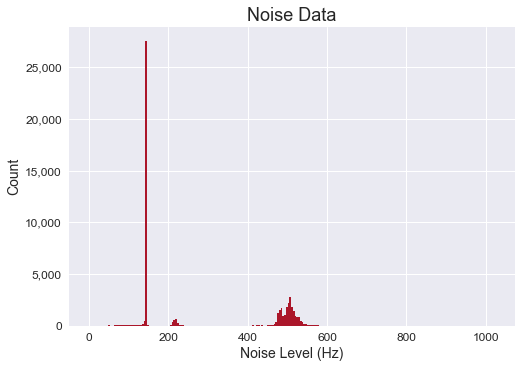

In [31]:
# Histogram of noise data
n_data = len(noise_data.noise)
n_bins = np.sqrt(n_data)
n_bins = int(n_bins)

fig, ax = plt.subplots()

ax.hist(noise_data['noise'], bins=n_bins, range=(noise_data['noise'].min(), noise_data['noise'].max()))
plt.title('Noise Data', size=18)
plt.xlabel('Noise Level (Hz)', size=14)
plt.ylabel('Count', size=14)
plt.tick_params(labelsize=12)
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
#plt.savefig('exploratory_data_analysis/noise_histogram.png')

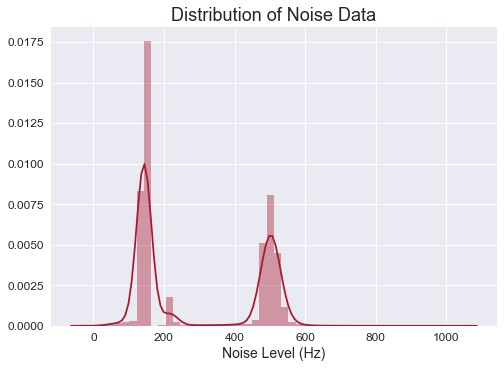

In [32]:
# Distribution of noise of data
sns.distplot(noise_data['noise'])

plt.title('Distribution of Noise Data', size=18)
plt.xlabel('Noise Level (Hz)', size=14)
plt.tick_params(labelsize=12)

In [33]:
# Create noise dataframe with a daily PeriodIndex: noise_period
noise_period = noise_data.to_period(freq='D')

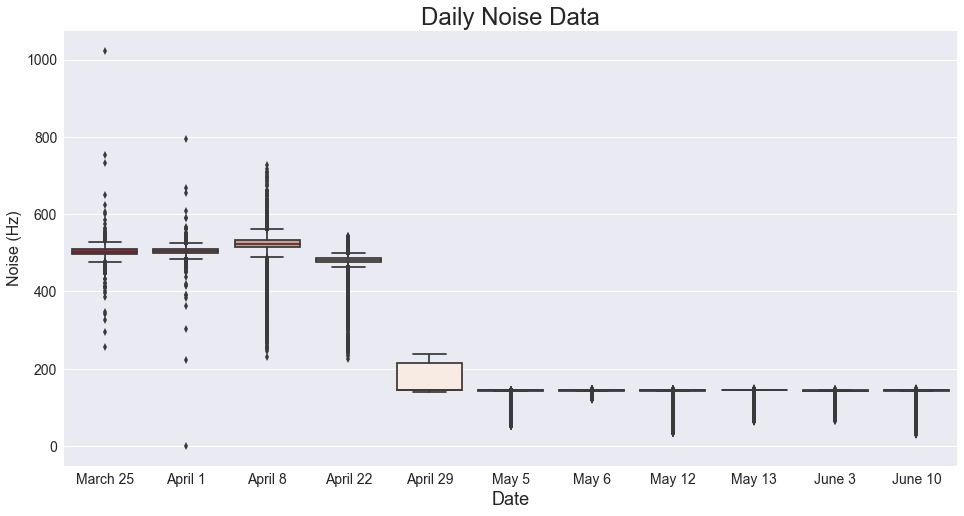

In [34]:
# Box-and-whisker plots of daily noise data
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(x=noise_period.index, y='noise', data=noise_period,
            ax=ax, palette=sns.color_palette('RdBu', 10))

labels = (['March 25', 'April 1', 'April 8', 'April 22', 'April 29', 'May 5',
           'May 6', 'May 12', 'May 13', 'June 3', 'June 10'])
ax.set_title('Daily Noise Data',fontsize= 24) 
ax.set_xlabel('Date', fontsize=18)
ax.set_xticklabels(labels)
ax.set_ylabel('Noise (Hz)', fontsize=16)
plt.tick_params(labelsize=14)
#plt.savefig('exploratory_data_analysis/daily_noise_boxplots.png')

### Light Data <a name='light'></a>
Illuminance is measured in foot candles or lux (in the metric SI system). GSA recommends a nominal illumination level (Lumens/Square Meter lux) of 300 for conference rooms, or 500 Lux in work station space, open and closed offices, and in training rooms.

In [35]:
# Create light dataframe with DateTimeIndex: light_data
light_data = df[['light']].copy()

In [36]:
light_data.info()
light_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53752 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 1 columns):
light    53752 non-null float64
dtypes: float64(1)
memory usage: 839.9 KB


,light
count,5.375200e+04
mean,8.189929e+03
std,2.327524e+05
min,0.000000e+00
25%,1.790000e+02
50%,2.070000e+02
75%,3.770000e+02
max,1.000000e+07


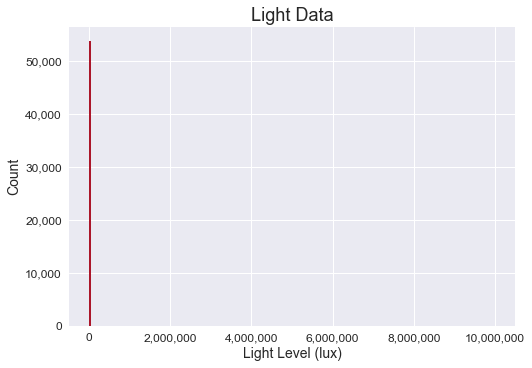

In [37]:
# Histogram of light data
n_data = len(light_data.light)
n_bins = np.sqrt(n_data)
n_bins = int(n_bins)

fig, ax = plt.subplots()

ax.hist(light_data['light'], bins=n_bins, range=(light_data['light'].min(), light_data['light'].max()))
plt.title('Light Data', size=18)
plt.xlabel('Light Level (lux)', size=14)
plt.ylabel('Count', size=14)
plt.tick_params(labelsize=12)
ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x,  p: format(int(x), ',')))
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
#plt.savefig('exploratory_data_analysis/light_histogram.png')

In [38]:
# Create light dataframe with a daily PeriodIndex: light_period
light_period = light_data.to_period(freq='D')

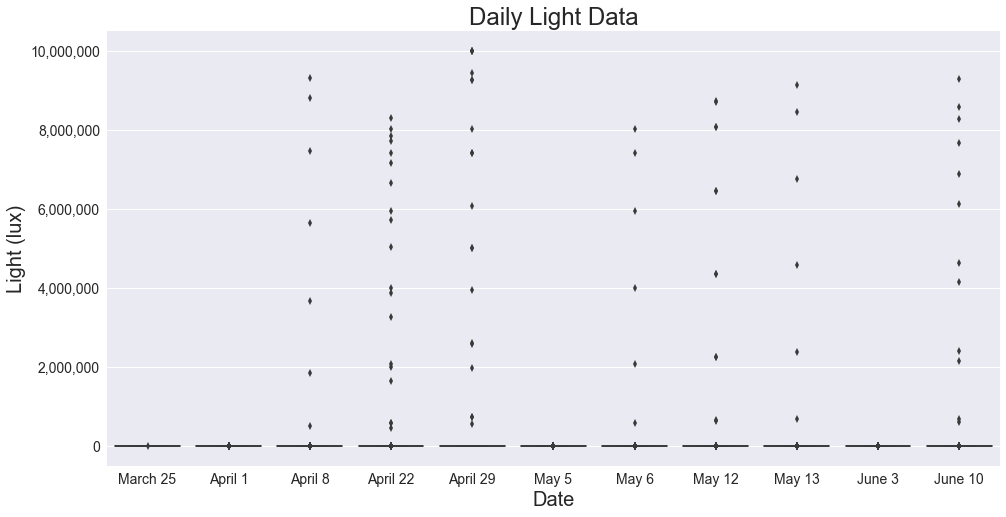

In [39]:
# Box-and-whiskers plots of daily light data
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(x=light_period.index, y='light', data=light_period, ax=ax, palette=sns.color_palette('RdBu', 10))

labels = (['March 25', 'April 1', 'April 8', 'April 22', 'April 29', 'May 5',
           'May 6', 'May 12', 'May 13', 'June 3', 'June 10'])
ax.set_title('Daily Light Data', fontsize=24)
ax.set_xlabel('Date', fontsize=20)
ax.set_xticklabels(labels)
ax.set_ylabel('Light (lux)', fontsize=20)
plt.tick_params(labelsize=14)
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
#plt.savefig('exploratory_data_analysis/daily_light_boxplots.png')

The light sensor generated several large error values or 0 readings when it would restart. In addition, it also generated error values at the end of the day when it was turned off. In the following plot of light data on May 5th, the light values never went over 400 lux until the final seconds of the day.

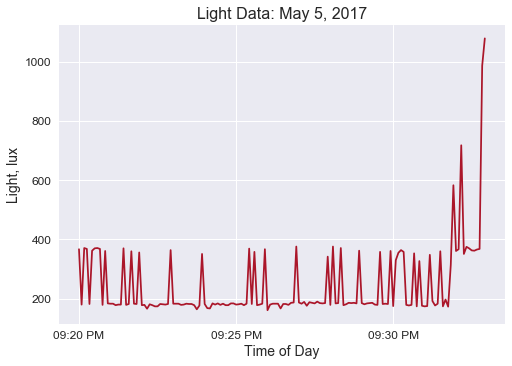

In [40]:
# Plot light data for May 5, 2017
fig, ax = plt.subplots()

ax.plot(light_data.loc['May 5, 2017 21:20:00':'May 5, 2017 22:00:00'])
plt.title('Light Data: May 5, 2017', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Light, lux', fontsize=14)
plt.tick_params(labelsize=12)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))
#plt.savefig('exploratory_data_analysis/light_may5.png')

In [41]:
# Delete error light values
light_data = light_data[light_data['light'] < 4000]

In [42]:
light_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53669 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 1 columns):
light    53669 non-null float64
dtypes: float64(1)
memory usage: 838.6 KB


While a light value of 0 is possible, it's unlikely since even with the classroom lights turned off, there still would have been light from the hallway. In addition, I concluded that these 0 values were errors since they were isolated readings, as can be seen below.

In [43]:
light_data.light['March 25, 2017 11:48:20':'March 25, 2017 11:49:00']

datetime
2017-03-25 11:48:20    463.0
2017-03-25 11:48:25    454.0
2017-03-25 11:48:30    465.0
2017-03-25 11:48:35    232.5
2017-03-25 11:48:40      0.0
2017-03-25 11:48:45    462.0
2017-03-25 11:48:50    461.0
2017-03-25 11:48:55    445.0
2017-03-25 11:49:00    458.0
Name: light, dtype: float64

In [44]:
# Delete error 0 light values
light_data = light_data[light_data['light'] != 0]

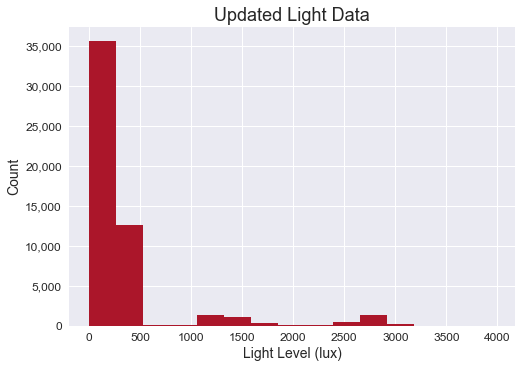

In [45]:
# Updated histogram of light data
fig, ax = plt.subplots()

ax.hist(light_data['light'], bins=15)
plt.title('Updated Light Data', size=18)
plt.xlabel('Light Level (lux)', size=14)
plt.ylabel('Count', size=14)
plt.tick_params(labelsize=12)
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
#plt.savefig('exploratory_data_analysis/updated_light_hist.png')

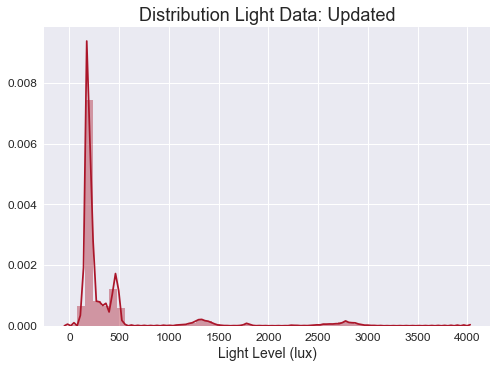

In [46]:
# Distribution of light data
sns.distplot(light_data['light'])

plt.title('Distribution Light Data: Updated', size=18)
plt.xlabel('Light Level (lux)', size=14)
plt.tick_params(labelsize=12)

In [47]:
# Create light dataframe with a daily PeriodIndex: light_period
light_period = light_data.to_period(freq='D')

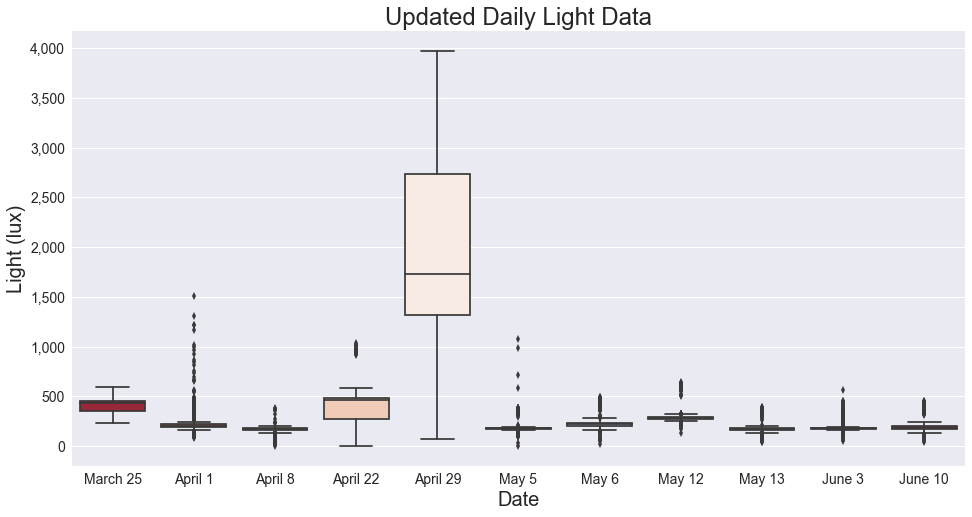

In [48]:
# Box-and-whiskers plots of daily light data
fig, ax = plt.subplots(figsize=(16,8))

sns.boxplot(x=light_period.index, y='light', data=light_period, ax=ax, palette=sns.color_palette('RdBu', 10))

labels = (['March 25', 'April 1', 'April 8', 'April 22', 'April 29', 'May 5',
           'May 6', 'May 12', 'May 13', 'June 3', 'June 10'])
ax.set_title('Updated Daily Light Data', fontsize=24)
ax.set_xlabel('Date', fontsize=20)
ax.set_xticklabels(labels)
ax.set_ylabel('Light (lux)', fontsize=20)
plt.tick_params(labelsize=14)
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
#plt.savefig('exploratory_data_analysis/light_boxplots_updated.png')

### Light Status<a name='light status'></a>
Categorical variable with two possible values: 'light-on' and 'light-off'

In [49]:
# Create light_status dataframe with DateTimeIndex: light_status
light_status = df[['light_status']].copy()

In [50]:
light_status.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53752 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 1 columns):
light_status    53752 non-null object
dtypes: object(1)
memory usage: 839.9+ KB


In [51]:
# Count the number of each category value
light_status['light_status'].value_counts()

light-on     48414
light-off     5338
Name: light_status, dtype: int64

### Bluetooth Devices<a name='bluetooth devices'></a>

In [52]:
# Create bluetooth devices dataframe with DateTimeIndex: bluetooth_data
bluetooth_data = df[['bluetooth_devices']].copy()

In [53]:
bluetooth_data.info()
bluetooth_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53752 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 1 columns):
bluetooth_devices    53752 non-null float64
dtypes: float64(1)
memory usage: 839.9 KB


,bluetooth_devices
count,53752.000000
mean,219.701799
std,139.380284
min,0.000000
25%,117.000000
50%,190.000000
75%,302.000000
max,635.000000


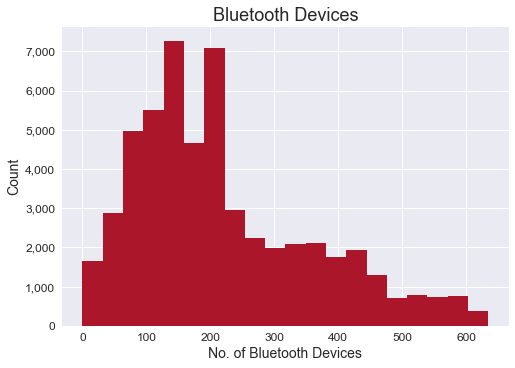

In [54]:
# Histogram of bluetooth data
fig, ax = plt.subplots()

ax.hist(bluetooth_data['bluetooth_devices'], bins=20)

plt.title('Bluetooth Devices', size=18)
plt.xlabel('No. of Bluetooth Devices', size=14)
plt.ylabel('Count', size=14)
plt.tick_params(labelsize=12)
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))

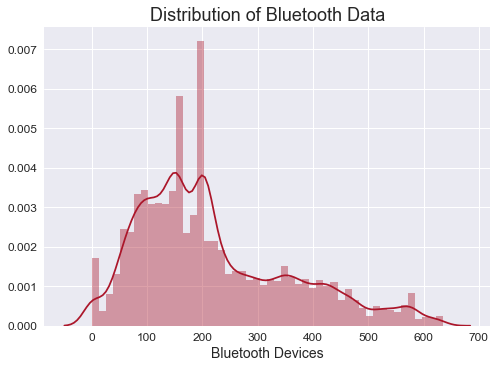

In [55]:
# Distribution of bluetooth data
sns.distplot(bluetooth_data['bluetooth_devices'])

plt.title('Distribution of Bluetooth Data', size=18)
plt.xlabel('Bluetooth Devices', size=14)
plt.tick_params(labelsize=12)

In [56]:
# Create bluetooth dataframe with a daily PeriodIndex
bluetooth_period = bluetooth_data.to_period(freq='D')

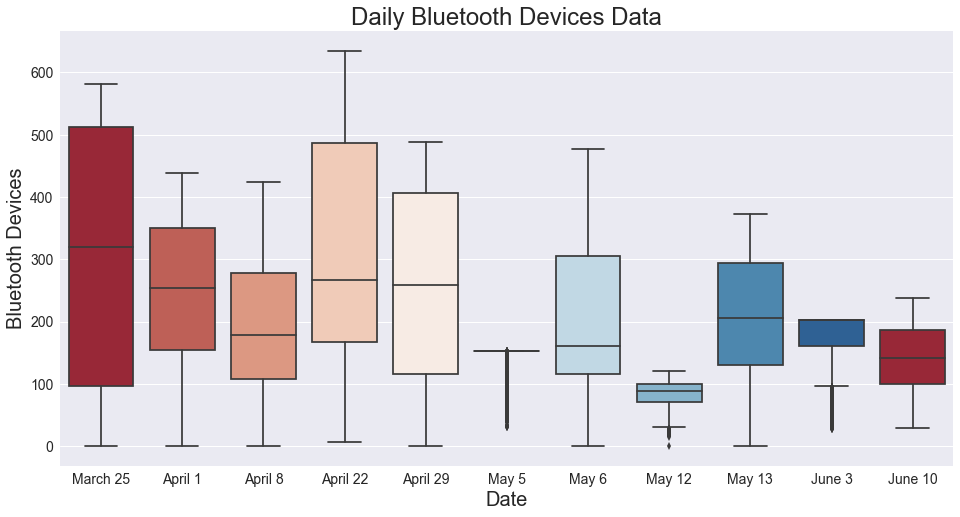

In [57]:
# Box-and-whiskers plots of daily bluetooth data
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x=bluetooth_period.index, y='bluetooth_devices', data=bluetooth_period,
            ax=ax, palette=sns.color_palette('RdBu', 10))

labels = (['March 25', 'April 1', 'April 8', 'April 22', 'April 29', 'May 5',
           'May 6', 'May 12', 'May 13', 'June 3', 'June 10'])
ax.set_title('Daily Bluetooth Devices Data', fontsize=24)
ax.set_xlabel('Date', fontsize=20)
ax.set_xticklabels(labels)
ax.set_ylabel('Bluetooth Devices', fontsize=20)
plt.tick_params(labelsize=14)
#plt.savefig('exploratory_data_analysis/daily_bluetooth.png')

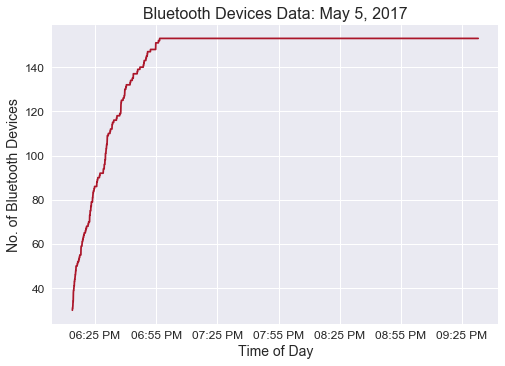

In [58]:
# Plot bluetooth data for May 5, 2017
fig, ax = plt.subplots()

ax.plot(bluetooth_data.loc['May 5, 2017'])
plt.title('Bluetooth Devices Data: May 5, 2017', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('No. of Bluetooth Devices', fontsize=14)
plt.tick_params(labelsize=12)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))
#plt.savefig('exploratory_data_analysis/bluetooth_may5.png')

### Images<a name='images'></a>

In [59]:
# Create image dataframe with DateTimeIndex: image_data
image_data = df[['image_hist_change']].copy()

In [60]:
image_data.info()
image_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53752 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 1 columns):
image_hist_change    53752 non-null float64
dtypes: float64(1)
memory usage: 839.9 KB


,image_hist_change
count,53752.000000
mean,13.388248
std,5.641866
min,1.982398
25%,10.049314
50%,12.090146
75%,15.849027
max,64.560408


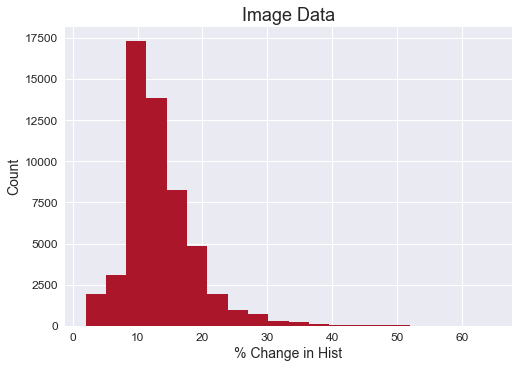

In [61]:
# Histogram of image data
plt.hist(image_data['image_hist_change'], bins=20)

plt.title('Image Data', size=18)
plt.xlabel('% Change in Hist', size=14)
plt.ylabel('Count', size=14)
plt.tick_params(labelsize=12)

In [62]:
# Create image dataframe with a daily PeriodIndex: image_period
image_period = image_data.to_period(freq='D')

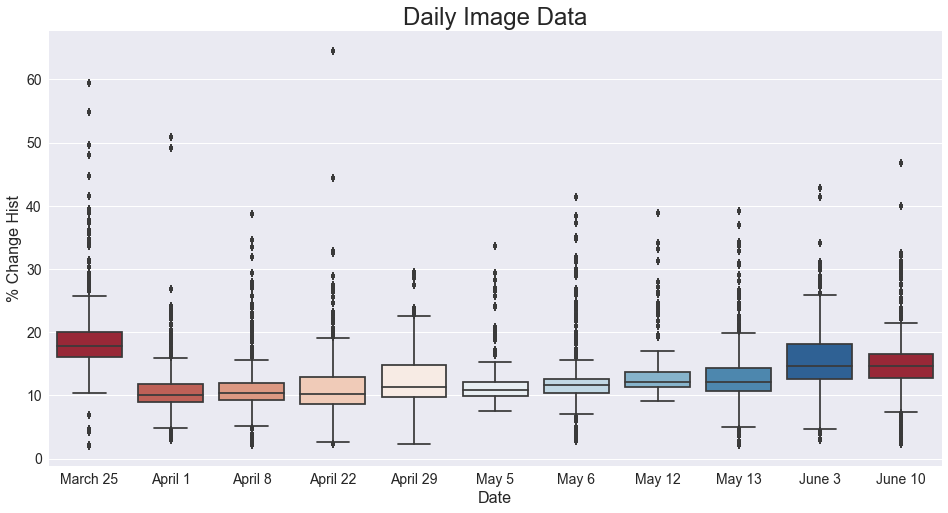

In [63]:
# Box-and-whiskers plots of daily image data
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x=image_period.index, y='image_hist_change',
            data=image_period, ax=ax, palette=sns.color_palette('RdBu', 10))

labels = (['March 25', 'April 1', 'April 8', 'April 22', 'April 29', 'May 5',
           'May 6', 'May 12', 'May 13', 'June 3', 'June 10'])
ax.set_title('Daily Image Data', fontsize=24)
ax.set_xlabel('Date', fontsize=16)
ax.set_xticklabels(labels)
ax.set_ylabel('% Change Hist', fontsize=16)
plt.tick_params(labelsize=14)
#plt.savefig('exploratory_data_analysis/daily_bluetooth_devices.png')

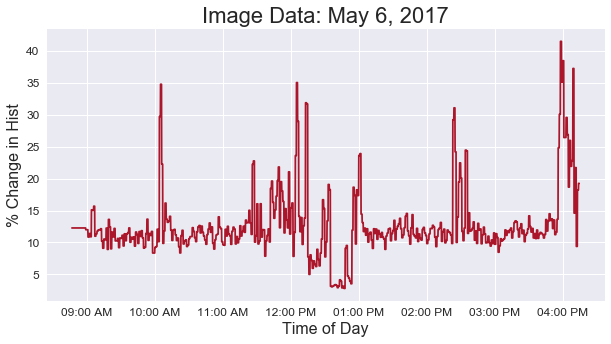

In [64]:
# Plot image data for May 6, 2017
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(image_data.loc['May 6, 2017'])
plt.title('Image Data: May 6, 2017', fontsize=22)
plt.xlabel('Time of Day', fontsize=16)
plt.ylabel('% Change in Hist', fontsize=16)
plt.tick_params(labelsize=12)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))
#plt.savefig('images_may6.png')

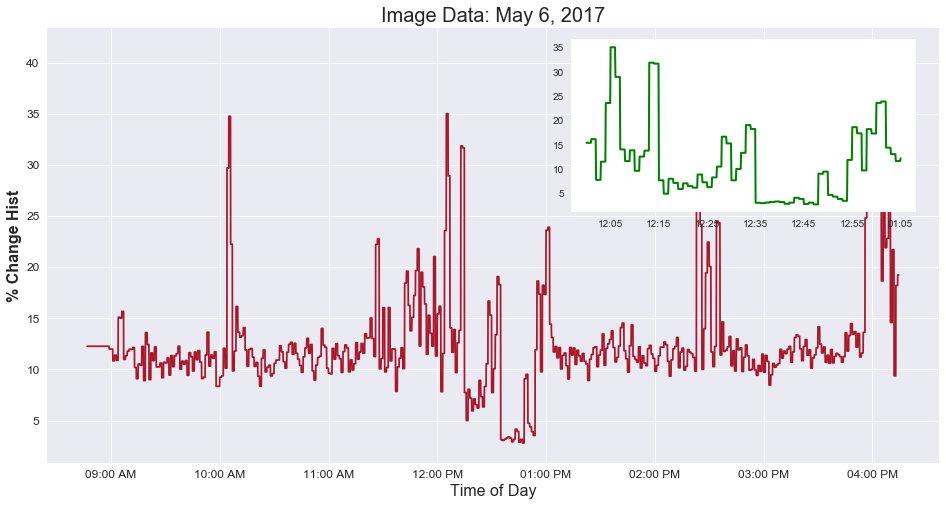

In [65]:
# Plot spike in image data on May 6, 2017
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(image_data.loc['May 6, 2017'])
ax.set_title('Image Data: May 6, 2017', fontsize=20)
ax.set_ylabel('% Change Hist', fontsize=16, weight='bold')
ax.set_xlabel('Time of Day', fontsize=16)
plt.tick_params(labelsize=12)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))

ax = plt.axes([.58, .56, .3, .3], facecolor='w')
ax.plot(image_data['image_hist_change'].loc['2017-05-06 12:00:00':'2017-05-06 13:05:00'].index, 
        image_data['image_hist_change'].loc['2017-05-06 12:00:00':'2017-05-06 13:05:00'], 'g', linewidth=2.0)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M'))
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
#plt.savefig('exploratory_data_analysis/image_lunch_may6.png')

### Door Status<a name='door status'></a>
Categorical variable with two possible values: 'closed' and 'opened'

In [66]:
# Create door status dataframe with DateTimeIndex: door_status
door_status = df[['door_status']].copy()

In [67]:
# Count the number of each category value
door_status['door_status'].value_counts()

closed    43844
opened     9908
Name: door_status, dtype: int64

### Occupancy Count<a name='occupancy count'></a>

In [68]:
# Create occupancy count dataframe with DateTimeIndex: occupancy_count
occupancy_count = df[['occupancy_count']].copy()

In [69]:
occupancy_count.info()
occupancy_count.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53752 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 1 columns):
occupancy_count    53752 non-null float64
dtypes: float64(1)
memory usage: 839.9 KB


,occupancy_count
count,53752.000000
mean,23.987889
std,9.954423
min,0.000000
25%,24.000000
50%,29.000000
75%,30.000000
max,31.000000


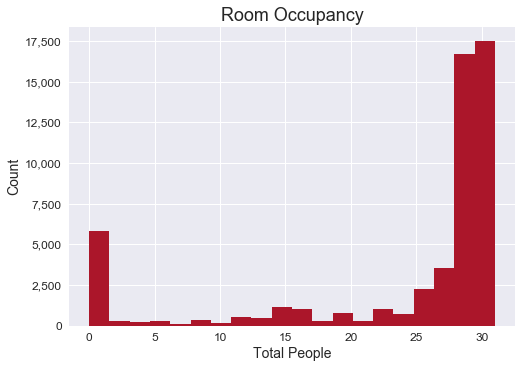

In [70]:
# Histogram of occupancy data
fig, ax = plt.subplots()

ax.hist(occupancy_count['occupancy_count'], bins=20)
plt.title('Room Occupancy', size=18)
plt.xlabel('Total People', size=14)
plt.ylabel('Count', size=14)
plt.tick_params(labelsize=12)
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: format(int(y), ',')))

In [71]:
# Create 'occupancy_count' dataframe with a daily PeriodIndex: occupancy_period
occupancy_period = occupancy_count.to_period(freq='D')

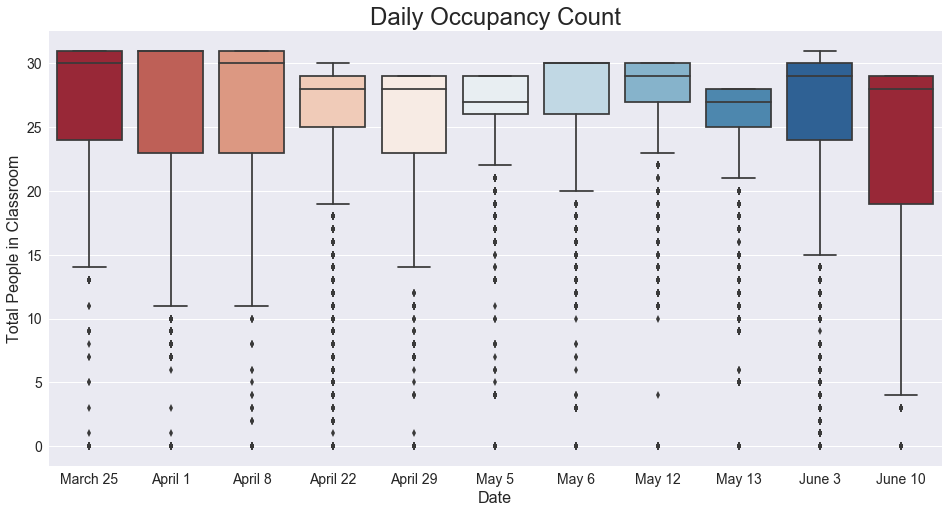

In [72]:
# Box-and-whiskers plots of daily 'occupancy_count' data
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x=occupancy_period.index, y='occupancy_count',
            data=occupancy_period, ax=ax, palette=sns.color_palette('RdBu', 10))

labels = (['March 25', 'April 1', 'April 8', 'April 22', 'April 29', 'May 5',
           'May 6', 'May 12', 'May 13', 'June 3', 'June 10'])
ax.set_title('Daily Occupancy Count', fontsize=24)
ax.set_xlabel('Date', fontsize=16)
ax.set_xticklabels(labels)
ax.set_ylabel('Total People in Classroom', fontsize=16)
plt.tick_params(labelsize=14)
#plt.savefig('exploratory_data_analysis/daily_occupancy.png')

## Concatenate Sensor Data<a name='concatenate data'></a>
Concatenate temperature, humidity, CO&#8322;, light, light status, noise, bluetooth, image, door_status, and occupancy count data into a new pandas dateframe

In [77]:
# Concatenate cleaned sensor data in a new dataframe: sensor_all
# Backward fill missing data
sensor_all = pd.concat([temperature_data, humidity_data, co2_data, noise_data, light_data,
                        light_status, bluetooth_data, image_data, door_status, occupancy_count], axis=1).fillna(method='bfill')

### Dummy Variables<a name='dummy variables'></a>

In [79]:
# Create dummy variables with drop_first=True: sensor_data
sensor_data = pd.get_dummies(sensor_all, drop_first=True)

# Print the new columns of df
sensor_data.columns

Index(['temperature', 'humidity', 'co2', 'noise', 'light', 'bluetooth_devices',
       'image_hist_change', 'occupancy_count', 'light_status_light-on',
       'door_status_opened'],
      dtype='object')

In [80]:
# Rearrange columns
sensor_data = sensor_data[['temperature', 'humidity', 'co2', 'light', 'light_status_light-on', 'noise',
         'bluetooth_devices', 'image_hist_change', 'door_status_opened', 'occupancy_count']]

In [81]:
sensor_data.columns = [['temp', 'humidity', 'co2', 'light', 'light_status', 'noise',
                        'bluetooth_devices', 'images', 'door_status', 'occupancy_count']]

In [82]:
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53752 entries, 2017-03-25 09:05:55 to 2017-06-10 16:47:05
Data columns (total 10 columns):
temp                 53752 non-null float64
humidity             53752 non-null float64
co2                  53752 non-null float64
light                53752 non-null float64
light_status         53752 non-null uint8
noise                53752 non-null float64
bluetooth_devices    53752 non-null float64
images               53752 non-null float64
door_status          53752 non-null uint8
occupancy_count      53752 non-null float64
dtypes: float64(8), uint8(2)
memory usage: 3.8 MB


## Resample Data<a name='resample data'></a>

In [83]:
# Resample data by taking the mean per minute
sensor_data = sensor_data.resample('T').mean().dropna()

## Create Category Variable<a name='occupancy level'></a>

In [84]:
# Create target array by slicing 'occupancy_count' column: occupancy_level
sensor_data['occupancy_level'] = pd.cut(sensor_data['occupancy_count'], [0, 1, 16, 27, 45],
                                        labels=['empty', 'low', 'mid-level', 'high'], include_lowest=True)

In [85]:
# Breakdown of classroom occupancy levels
sensor_data.occupancy_level.value_counts()

high         2881
mid-level     781
empty         482
low           348
Name: occupancy_level, dtype: int64

## Save Data <a name='save data'></a>

In [86]:
# Export updated sensor data to a CSV file: sensor_data_ml.csv
sensor_data.to_csv('sensor_data_ml.csv')

### [Return to Table of Contents](#table of contents)